In [15]:
import torch
import numpy as np
import random

In [61]:
params = {'seed': 0,
          'topk': 1,
          'n_neighbors': 50,
          'average_method': 'min',
          'affine_power_a': 6,
          'prior_lambda': 5e-3,
          'num_labels': len(actions_dict),
          'smooth': 10}

def run_random_walk(frames, prior, params):
  w_mat = get_affinity_matrix(frames,
                              simillarity_method='cosine',
                              post_process_fn=functools.partial(power,
                                                      a=params['affine_power_a']))
  sparse_w_mat = sparsify_affine_matrix(w_mat,
                                        m=params['n_neighbors'],
                                        average_method=params['average_method'])
  lap = csgraph.laplacian(sparse_w_mat,
                          normed=False)

  preds = predict(lap, prior, params['prior_lambda'])
  return preds

# test
# prior = extract_prior(list_of_examples[0], gt_path, timestamps_dict, actions_dict, value=1., smooth=params['smooth'])
# features = np.load(features_path + list_of_examples[0].split('.')[0] + '.npy').T
# p = run_random_walk(features, prior, params)

In [91]:
import matplotlib.pyplot as plt 

def plot_bars_with_seeds(labels, preds, timestamps):
  n = len(preds)
  x = np.arange(n)
  ss = [100] * n

  xs = timestamps
  ys = [labels[t] for t in timestamps]

  plt.scatter(xs, [1.1]*len(xs), c=ys, edgecolors="black", cmap='jet')
  plt.scatter(x, [1.2]*n, s=ss, marker="|", c=preds, cmap='jet')
  plt.scatter(x, [1]*n, s=ss, marker="|", c=labels, cmap='jet')

  plt.annotate("GT",(1, 1.02))
  plt.annotate("Seeds",(1, 1.12))
  plt.annotate("Preds",(1, 1.22))

  plt.ylim([0.9, 1.3])
  plt.yticks([])
  plt.show()


Loaded 28 files
Finish vid: S2_Cheese_C1.txt | Acc 0.505


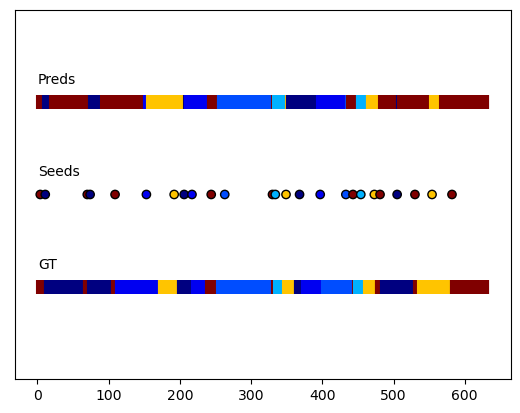

Finish vid: S2_CofHoney_C1.txt | Acc 0.708
Finish vid: S2_Coffee_C1.txt | Acc 0.466
Finish vid: S2_Hotdog_C1.txt | Acc 0.626
Finish vid: S2_Pealate_C1.txt | Acc 0.572
Finish vid: S2_Peanut_C1.txt | Acc 0.735


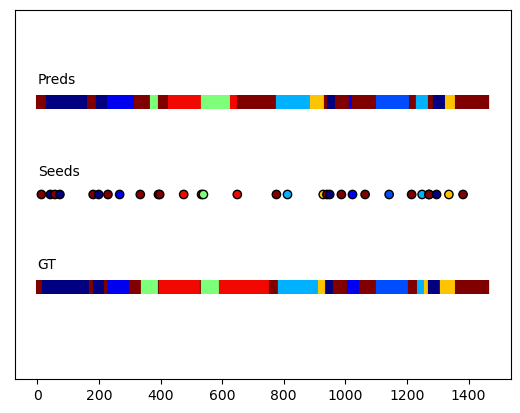

Finish vid: S2_Tea_C1.txt | Acc 0.641
Finish vid: S3_Cheese_C1.txt | Acc 0.582
Finish vid: S3_CofHoney_C1.txt | Acc 0.599
Finish vid: S3_Coffee_C1.txt | Acc 0.657
Finish vid: S3_Hotdog_C1.txt | Acc 0.655


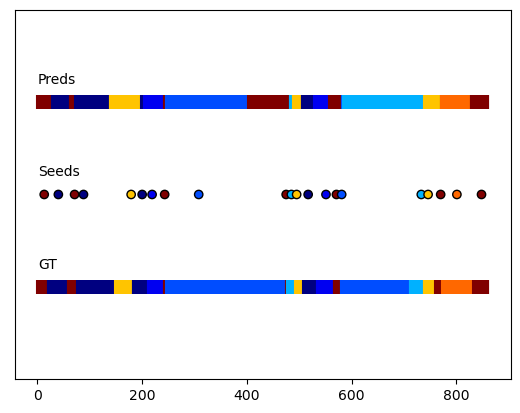

Finish vid: S3_Pealate_C1.txt | Acc 0.683
Finish vid: S3_Peanut_C1.txt | Acc 0.648
Finish vid: S3_Tea_C1.txt | Acc 0.615
Finish vid: S4_Cheese_C1.txt | Acc 0.708
Finish vid: S4_CofHoney_C1.txt | Acc 0.635


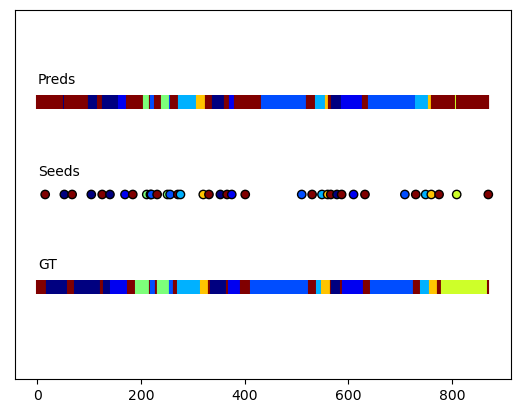

Finish vid: S4_Coffee_C1.txt | Acc 0.584
Finish vid: S4_Hotdog_C1.txt | Acc 0.737
Finish vid: S4_Pealate_C1.txt | Acc 0.487
Finish vid: S4_Peanut_C1.txt | Acc 0.639
Finish vid: S4_Tea_C1.txt | Acc 0.705


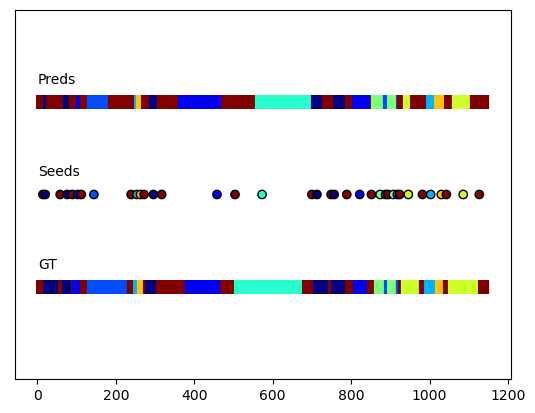

Finish vid: S1_Cheese_C1.txt | Acc 0.494
Finish vid: S1_CofHoney_C1.txt | Acc 0.527
Finish vid: S1_Coffee_C1.txt | Acc 0.550
Finish vid: S1_Hotdog_C1.txt | Acc 0.602
Finish vid: S1_Pealate_C1.txt | Acc 0.626


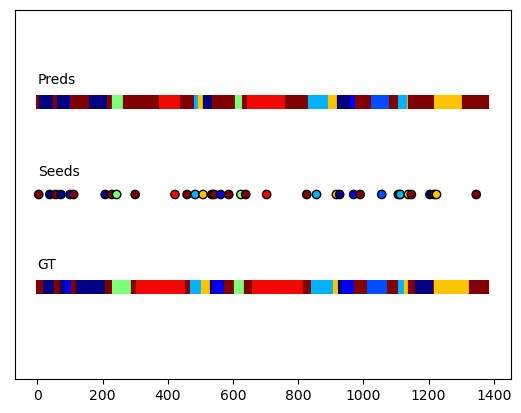

Finish vid: S1_Peanut_C1.txt | Acc 0.666
Finish vid: S1_Tea_C1.txt | Acc 0.587
Finish all videos, mean acc: 0.616


In [92]:
def run_naive_method_over_dataset(dataset = '50salads', plot_every=5):
  vid_name2naive_preds = {}
  acc = []
  split = '1'

  vid_list_file = "./data/"+dataset+"/splits/train.split"+split+".bundle"
  vid_list_file_tst = "./data/"+dataset+"/splits/test.split"+split+".bundle"
  features_path = "./data/"+dataset+"/features/"
  gt_path = "./data/"+dataset+"/groundTruth/"
  mapping_file = "./data/"+dataset+"/mapping.txt"

  file_ptr = open(vid_list_file, 'r')
  list_of_examples_train = file_ptr.read().split('\n')[:-1]
  file_ptr.close()
  file_ptr = open(vid_list_file_tst, 'r')
  list_of_examples_test = file_ptr.read().split('\n')[:-1]
  file_ptr.close()
  list_of_examples = list_of_examples_train + list_of_examples_test
  print('Loaded {} files'.format(len(list_of_examples)))

  timestamps_dict = np.load(gt_path + dataset + "_annotation_all.npy", allow_pickle=True).item()

  file_ptr = open(mapping_file, 'r')
  actions = file_ptr.read().split('\n')[:-1]
  file_ptr.close()
  actions_dict = dict()
  for a in actions:
      actions_dict[a.split()[1]] = int(a.split()[0])

  for i, vid_name in enumerate(list_of_examples):
    file_ptr = open(gt_path + vid_name, 'r')
    labels_str = file_ptr.read().split('\n')[:-1]
    labels = [actions_dict[l] for l in labels_str]
    timestamps = timestamps_dict[vid_name]
    features = np.load(features_path + vid_name.split('.')[0] + '.npy').T
    if dataset == '50salads':
      features = features[::2, :]
      labels = labels[::2]

    preds = run_naive_method(timestamps, labels, features)
    acc.append((labels == preds).mean())
    vid_name2naive_preds[vid_name] = preds
    print('Finish vid: {} | Acc {:.3f}'.format(vid_name, acc[-1]))
    if i % plot_every == 0:
     plot_bars_with_seeds(labels, preds, timestamps)
  print('Finish all videos, mean acc: {:.3f}'.format(np.mean(acc)))
  naive_file_name = "./data/"+dataset+"/naive_preds.pickle"
  with open(naive_file_name, 'wb') as handle:
    pickle.dump(vid_name2naive_preds, handle)


def run_naive_method(timestamps, labels, features):
    features = torch.tensor(features)
    boundary_target = np.ones((len(labels))) * (-100)
    boundary_target[:timestamps[0]] = labels[timestamps[0]]  # frames before first single frame has same label
    left_bound = [0]

    # Forward to find action boundaries
    for i in range(len(timestamps) - 1):
        start = timestamps[i]
        end = timestamps[i + 1] + 1
        left_score = torch.zeros(end - start - 1, dtype=torch.float)
        for t in range(start + 1, end):
            center_left = torch.mean(features[:, left_bound[-1]:t], dim=1)
            diff_left = features[:, start:t] - center_left.reshape(-1, 1)
            score_left = torch.mean(torch.norm(diff_left, dim=0))

            center_right = torch.mean(features[:, t:end], dim=1)
            diff_right = features[:, t:end] - center_right.reshape(-1, 1)
            score_right = torch.mean(torch.norm(diff_right, dim=0))

            left_score[t-start-1] = ((t-start) * score_left + (end - t) * score_right)/(end - start)

        cur_bound = torch.argmin(left_score) + start + 1
        left_bound.append(cur_bound.item())

    # Backward to find action boundaries
    right_bound = [len(labels)]
    for i in range(len(timestamps) - 1, 0, -1):
        start = timestamps[i - 1]
        end = timestamps[i] + 1
        right_score = torch.zeros(end - start - 1, dtype=torch.float)
        for t in range(end - 1, start, -1):
            center_left = torch.mean(features[:, start:t], dim=1)
            diff_left = features[:, start:t] - center_left.reshape(-1, 1)
            score_left = torch.mean(torch.norm(diff_left, dim=0))

            center_right = torch.mean(features[:, t:right_bound[-1]], dim=1)
            diff_right = features[:, t:end] - center_right.reshape(-1, 1)
            score_right = torch.mean(torch.norm(diff_right, dim=0))

            right_score[t-start-1] = ((t-start) * score_left + (end - t) * score_right)/(end - start)

        cur_bound = torch.argmin(right_score) + start + 1
        right_bound.append(cur_bound.item())

    # Average two action boundaries for same segment and generate pseudo labels
    left_bound = left_bound[1:]
    right_bound = right_bound[1:]
    num_bound = len(left_bound)
    for i in range(num_bound):
        temp_left = left_bound[i]
        temp_right = right_bound[num_bound - i - 1]
        middle_bound = int((temp_left + temp_right)/2)
        boundary_target[timestamps[i]:middle_bound] = labels[timestamps[i]]
        boundary_target[middle_bound:timestamps[i + 1] + 1] = labels[timestamps[i + 1]]
    boundary_target[timestamps[-1]:] = labels[timestamps[-1]]  # frames after last single frame has same label

    return boundary_target

run_naive_method_over_dataset(dataset='gtea')


Loaded 50 files
Finish vid: rgb-06-1.txt | Acc 0.622


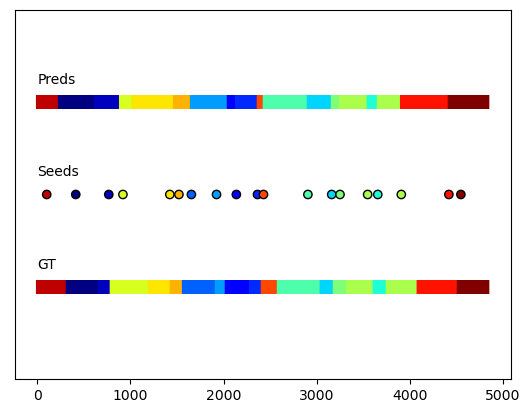

Finish vid: rgb-06-2.txt | Acc 0.573
Finish vid: rgb-07-1.txt | Acc 0.545
Finish vid: rgb-07-2.txt | Acc 0.545
Finish vid: rgb-09-1.txt | Acc 0.607
Finish vid: rgb-09-2.txt | Acc 0.643
Finish vid: rgb-10-1.txt | Acc 0.728
Finish vid: rgb-10-2.txt | Acc 0.613
Finish vid: rgb-11-1.txt | Acc 0.682
Finish vid: rgb-11-2.txt | Acc 0.637
Finish vid: rgb-13-1.txt | Acc 0.593


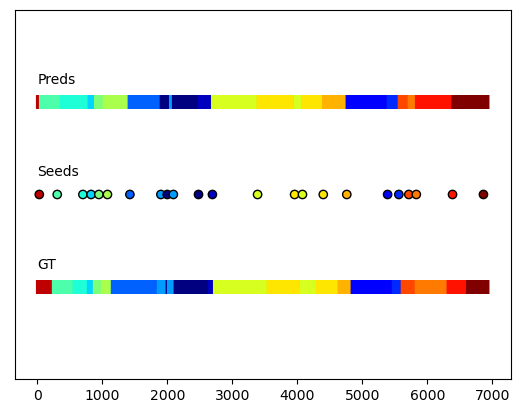

Finish vid: rgb-13-2.txt | Acc 0.590
Finish vid: rgb-14-1.txt | Acc 0.595
Finish vid: rgb-14-2.txt | Acc 0.616
Finish vid: rgb-15-1.txt | Acc 0.644
Finish vid: rgb-15-2.txt | Acc 0.648
Finish vid: rgb-16-1.txt | Acc 0.628
Finish vid: rgb-16-2.txt | Acc 0.539
Finish vid: rgb-17-1.txt | Acc 0.596
Finish vid: rgb-17-2.txt | Acc 0.473
Finish vid: rgb-18-1.txt | Acc 0.754


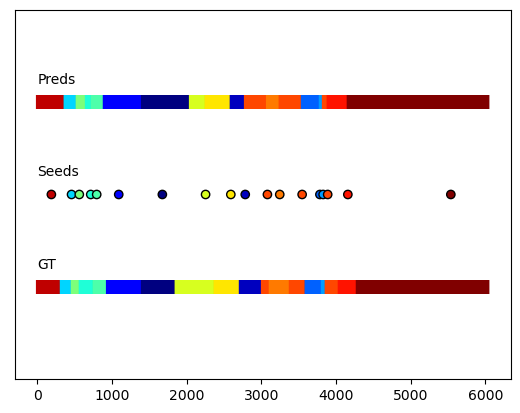

Finish vid: rgb-18-2.txt | Acc 0.700
Finish vid: rgb-19-1.txt | Acc 0.654
Finish vid: rgb-19-2.txt | Acc 0.708
Finish vid: rgb-20-1.txt | Acc 0.563
Finish vid: rgb-20-2.txt | Acc 0.668
Finish vid: rgb-21-1.txt | Acc 0.661
Finish vid: rgb-21-2.txt | Acc 0.632
Finish vid: rgb-22-1.txt | Acc 0.556
Finish vid: rgb-22-2.txt | Acc 0.600
Finish vid: rgb-23-1.txt | Acc 0.570


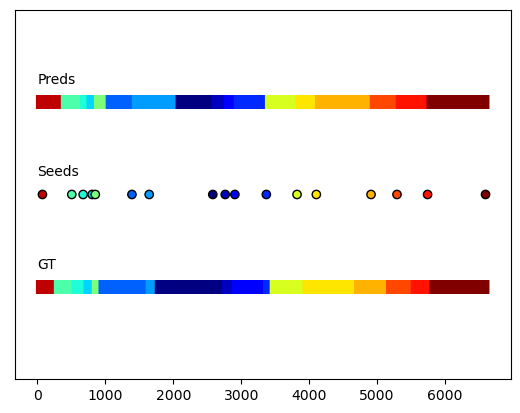

Finish vid: rgb-23-2.txt | Acc 0.675
Finish vid: rgb-24-1.txt | Acc 0.662
Finish vid: rgb-24-2.txt | Acc 0.551
Finish vid: rgb-25-1.txt | Acc 0.720
Finish vid: rgb-25-2.txt | Acc 0.676
Finish vid: rgb-26-1.txt | Acc 0.755
Finish vid: rgb-26-2.txt | Acc 0.644
Finish vid: rgb-27-1.txt | Acc 0.580
Finish vid: rgb-27-2.txt | Acc 0.789
Finish vid: rgb-01-1.txt | Acc 0.613


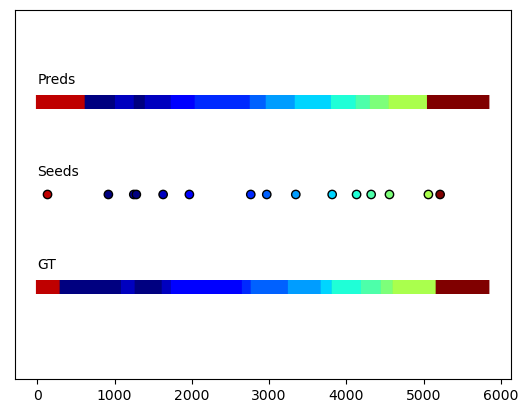

Finish vid: rgb-01-2.txt | Acc 0.558
Finish vid: rgb-02-1.txt | Acc 0.677
Finish vid: rgb-02-2.txt | Acc 0.691
Finish vid: rgb-03-1.txt | Acc 0.529
Finish vid: rgb-03-2.txt | Acc 0.459
Finish vid: rgb-04-1.txt | Acc 0.702
Finish vid: rgb-04-2.txt | Acc 0.591
Finish vid: rgb-05-1.txt | Acc 0.553
Finish vid: rgb-05-2.txt | Acc 0.618
Finish all videos, mean acc: 0.625


In [94]:
run_naive_method_over_dataset(dataset='50salads', plot_every=10)

Loaded 1712 files
Finish vid: P16_cam01_P16_cereals.txt | Acc 0.476


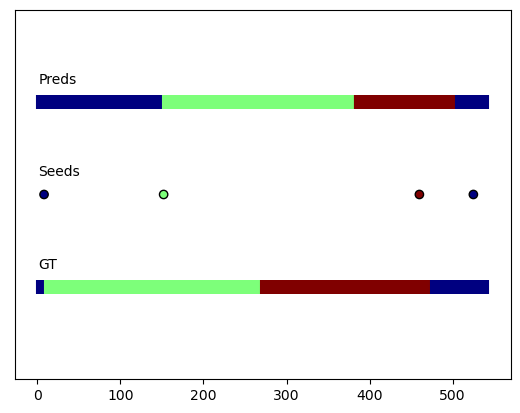

Finish vid: P16_cam01_P16_friedegg.txt | Acc 0.298
Finish vid: P16_cam01_P16_juice.txt | Acc 0.629
Finish vid: P16_cam01_P16_milk.txt | Acc 0.671
Finish vid: P16_cam01_P16_pancake.txt | Acc 0.288
Finish vid: P16_cam01_P16_salat.txt | Acc 0.511
Finish vid: P16_cam01_P16_sandwich.txt | Acc 0.736
Finish vid: P16_cam01_P16_tea.txt | Acc 0.840
Finish vid: P16_stereo01_P16_cereals.txt | Acc 0.490
Finish vid: P16_stereo01_P16_coffee.txt | Acc 0.690
Finish vid: P16_stereo01_P16_friedegg.txt | Acc 0.347
Finish vid: P16_stereo01_P16_juice.txt | Acc 0.611
Finish vid: P16_stereo01_P16_milk.txt | Acc 0.770
Finish vid: P16_stereo01_P16_pancake.txt | Acc 0.748
Finish vid: P16_stereo01_P16_salat.txt | Acc 0.388
Finish vid: P16_stereo01_P16_sandwich.txt | Acc 0.703
Finish vid: P16_stereo01_P16_scrambledegg.txt | Acc 0.405
Finish vid: P16_stereo01_P16_tea.txt | Acc 0.881
Finish vid: P16_webcam01_P16_cereals.txt | Acc 0.303
Finish vid: P16_webcam01_P16_friedegg.txt | Acc 0.320
Finish vid: P16_webcam01_P1

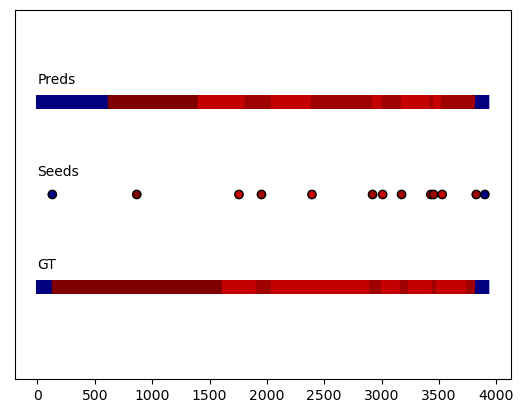

Finish vid: P18_webcam02_P18_sandwich.txt | Acc 0.780
Finish vid: P18_webcam02_P18_scrambledegg.txt | Acc 0.768
Finish vid: P18_webcam02_P18_tea.txt | Acc 0.808
Finish vid: P19_cam01_P19_cereals.txt | Acc 0.681
Finish vid: P19_cam01_P19_coffee.txt | Acc 0.846
Finish vid: P19_cam01_P19_friedegg.txt | Acc 0.588
Finish vid: P19_cam01_P19_juice.txt | Acc 0.407
Finish vid: P19_cam01_P19_milk.txt | Acc 0.755
Finish vid: P19_cam01_P19_pancake.txt | Acc 0.549
Finish vid: P19_cam01_P19_salat.txt | Acc 0.746
Finish vid: P19_cam01_P19_sandwich.txt | Acc 0.907
Finish vid: P19_cam01_P19_tea.txt | Acc 0.662
Finish vid: P19_stereo01_P19_cereals.txt | Acc 0.601
Finish vid: P19_stereo01_P19_milk.txt | Acc 0.722
Finish vid: P19_stereo01_P19_sandwich.txt | Acc 0.937
Finish vid: P19_stereo01_P19_tea.txt | Acc 0.576
Finish vid: P19_webcam01_P19_cereals.txt | Acc 0.724
Finish vid: P19_webcam01_P19_coffee.txt | Acc 0.862
Finish vid: P19_webcam01_P19_friedegg.txt | Acc 0.407
Finish vid: P19_webcam01_P19_juice

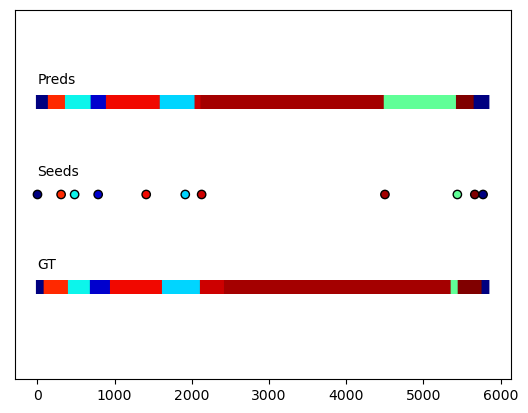

Finish vid: P21_webcam01_P21_salat.txt | Acc 0.636
Finish vid: P21_webcam01_P21_sandwich.txt | Acc 0.458
Finish vid: P21_webcam01_P21_scrambledegg.txt | Acc 0.606
Finish vid: P21_webcam01_P21_tea.txt | Acc 0.959
Finish vid: P21_webcam02_P21_cereals.txt | Acc 0.688
Finish vid: P21_webcam02_P21_coffee.txt | Acc 0.585
Finish vid: P21_webcam02_P21_friedegg.txt | Acc 0.597
Finish vid: P21_webcam02_P21_juice.txt | Acc 0.740
Finish vid: P21_webcam02_P21_milk.txt | Acc 0.726
Finish vid: P21_webcam02_P21_pancake.txt | Acc 0.641
Finish vid: P21_webcam02_P21_salat.txt | Acc 0.688
Finish vid: P21_webcam02_P21_sandwich.txt | Acc 0.450
Finish vid: P21_webcam02_P21_scrambledegg.txt | Acc 0.624
Finish vid: P21_webcam02_P21_tea.txt | Acc 0.855
Finish vid: P22_cam01_P22_cereals.txt | Acc 0.499
Finish vid: P22_cam01_P22_coffee.txt | Acc 0.969
Finish vid: P22_cam01_P22_friedegg.txt | Acc 0.623
Finish vid: P22_cam01_P22_juice.txt | Acc 0.770
Finish vid: P22_cam01_P22_milk.txt | Acc 0.810
Finish vid: P22_ca

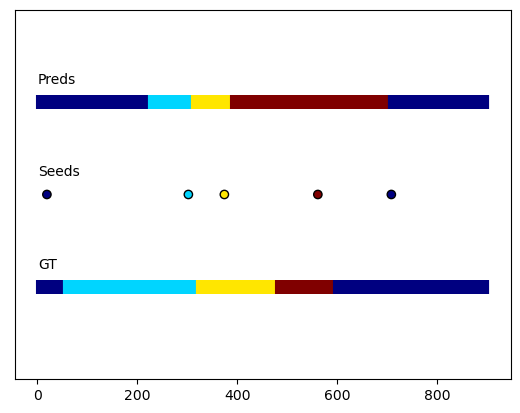

Finish vid: P24_cam01_P24_coffee.txt | Acc 0.634
Finish vid: P24_cam01_P24_friedegg.txt | Acc 0.629
Finish vid: P24_cam01_P24_juice.txt | Acc 0.793
Finish vid: P24_cam01_P24_milk.txt | Acc 0.606
Finish vid: P24_cam01_P24_pancake.txt | Acc 0.490
Finish vid: P24_cam01_P24_salat.txt | Acc 0.625
Finish vid: P24_cam01_P24_sandwich.txt | Acc 0.735
Finish vid: P24_cam01_P24_scrambledegg.txt | Acc 0.618
Finish vid: P24_cam01_P24_tea.txt | Acc 0.399
Finish vid: P24_cam02_P24_cereals.txt | Acc 0.379
Finish vid: P24_cam02_P24_coffee.txt | Acc 0.596
Finish vid: P24_cam02_P24_friedegg.txt | Acc 0.327
Finish vid: P24_cam02_P24_juice.txt | Acc 0.418
Finish vid: P24_cam02_P24_milk.txt | Acc 0.748
Finish vid: P24_cam02_P24_pancake.txt | Acc 0.615
Finish vid: P24_cam02_P24_salat.txt | Acc 0.539
Finish vid: P24_cam02_P24_sandwich.txt | Acc 0.741
Finish vid: P24_stereo01_P24_coffee.txt | Acc 0.835
Finish vid: P24_stereo01_P24_friedegg.txt | Acc 0.648
Finish vid: P24_stereo01_P24_salat.txt | Acc 0.684
Fini

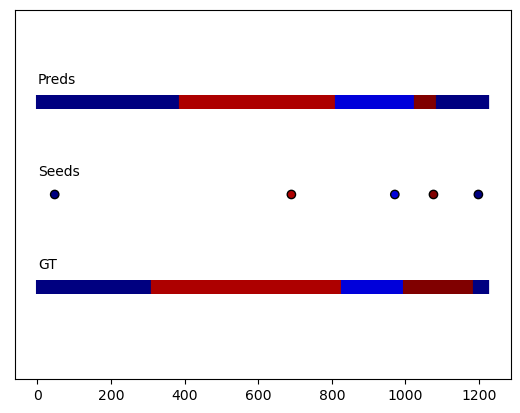

Finish vid: P26_webcam02_P26_pancake.txt | Acc 0.529
Finish vid: P26_webcam02_P26_salat.txt | Acc 0.229
Finish vid: P26_webcam02_P26_sandwich.txt | Acc 0.574
Finish vid: P26_webcam02_P26_scrambledegg.txt | Acc 0.653
Finish vid: P26_webcam02_P26_tea.txt | Acc 0.752
Finish vid: P27_cam01_P27_cereals.txt | Acc 0.765
Finish vid: P27_cam01_P27_coffee.txt | Acc 0.637
Finish vid: P27_cam01_P27_friedegg.txt | Acc 0.421
Finish vid: P27_cam01_P27_juice.txt | Acc 0.550
Finish vid: P27_cam01_P27_milk.txt | Acc 0.562
Finish vid: P27_cam01_P27_pancake.txt | Acc 0.368
Finish vid: P27_cam01_P27_salat.txt | Acc 0.525
Finish vid: P27_cam01_P27_sandwich.txt | Acc 0.665
Finish vid: P27_cam01_P27_scrambledegg.txt | Acc 0.580
Finish vid: P27_cam01_P27_tea.txt | Acc 0.745
Finish vid: P27_cam02_P27_cereals.txt | Acc 0.653
Finish vid: P27_cam02_P27_coffee.txt | Acc 0.442
Finish vid: P27_cam02_P27_friedegg.txt | Acc 0.538
Finish vid: P27_cam02_P27_juice.txt | Acc 0.631
Finish vid: P27_cam02_P27_milk.txt | Acc 0

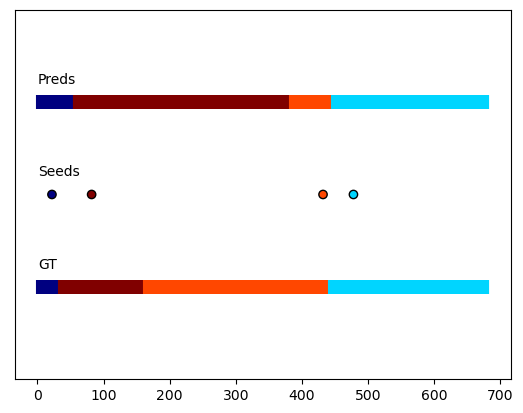

Finish vid: P31_cam01_P31_friedegg.txt | Acc 0.804
Finish vid: P31_cam01_P31_juice.txt | Acc 0.618
Finish vid: P31_cam01_P31_milk.txt | Acc 0.756
Finish vid: P31_cam01_P31_pancake.txt | Acc 0.673
Finish vid: P31_cam01_P31_salat.txt | Acc 0.775
Finish vid: P31_cam01_P31_sandwich.txt | Acc 0.731
Finish vid: P31_cam01_P31_scrambledegg.txt | Acc 0.484
Finish vid: P31_cam01_P31_tea.txt | Acc 0.814
Finish vid: P31_cam02_P31_cereals.txt | Acc 0.906
Finish vid: P31_cam02_P31_coffee.txt | Acc 0.805
Finish vid: P31_cam02_P31_friedegg.txt | Acc 0.436
Finish vid: P31_cam02_P31_juice.txt | Acc 0.780
Finish vid: P31_cam02_P31_milk.txt | Acc 0.514
Finish vid: P31_cam02_P31_pancake.txt | Acc 0.393
Finish vid: P31_cam02_P31_salat.txt | Acc 0.473
Finish vid: P31_cam02_P31_sandwich.txt | Acc 0.698
Finish vid: P31_cam02_P31_scrambledegg.txt | Acc 0.466
Finish vid: P31_cam02_P31_tea.txt | Acc 0.728
Finish vid: P31_stereo01_P31_coffee.txt | Acc 0.613
Finish vid: P31_stereo01_P31_milk.txt | Acc 0.656
Finish 

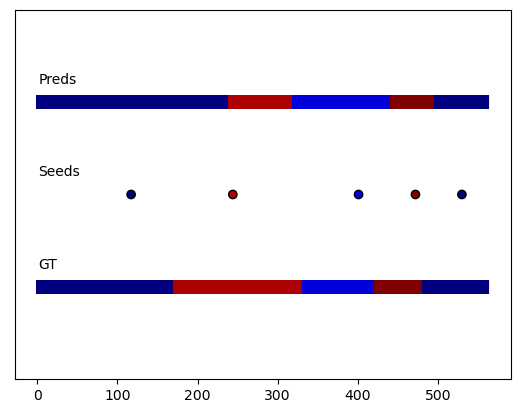

Finish vid: P35_cam01_P35_pancake.txt | Acc 0.566
Finish vid: P35_cam01_P35_salat.txt | Acc 0.580
Finish vid: P35_cam01_P35_sandwich.txt | Acc 0.789
Finish vid: P35_cam01_P35_scrambledegg.txt | Acc 0.680
Finish vid: P35_cam01_P35_tea.txt | Acc 0.582
Finish vid: P35_cam02_P35_cereals.txt | Acc 0.800
Finish vid: P35_cam02_P35_coffee.txt | Acc 0.657
Finish vid: P35_cam02_P35_tea.txt | Acc 0.475
Finish vid: P35_stereo01_P35_cereals.txt | Acc 0.799
Finish vid: P35_stereo01_P35_coffee.txt | Acc 0.279
Finish vid: P35_stereo01_P35_friedegg.txt | Acc 0.648
Finish vid: P35_stereo01_P35_juice.txt | Acc 0.662
Finish vid: P35_stereo01_P35_milk.txt | Acc 0.786
Finish vid: P35_stereo01_P35_salat.txt | Acc 0.688
Finish vid: P35_stereo01_P35_sandwich.txt | Acc 0.874
Finish vid: P35_stereo01_P35_scrambledegg.txt | Acc 0.807
Finish vid: P35_stereo01_P35_tea.txt | Acc 0.724
Finish vid: P35_webcam02_P35_cereals.txt | Acc 0.642
Finish vid: P35_webcam02_P35_coffee.txt | Acc 0.571
Finish vid: P35_webcam02_P35

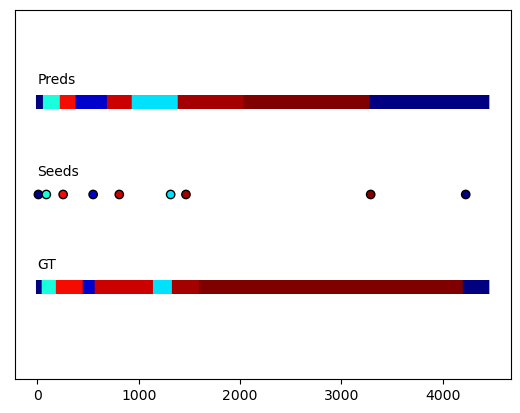

Finish vid: P37_webcam02_P37_salat.txt | Acc 0.471
Finish vid: P37_webcam02_P37_sandwich.txt | Acc 0.607
Finish vid: P37_webcam02_P37_scrambledegg.txt | Acc 0.713
Finish vid: P37_webcam02_P37_tea.txt | Acc 0.551
Finish vid: P38_cam01_P38_cereals.txt | Acc 0.621
Finish vid: P38_cam01_P38_coffee.txt | Acc 0.657
Finish vid: P38_cam01_P38_friedegg.txt | Acc 0.776
Finish vid: P38_cam01_P38_juice.txt | Acc 0.735
Finish vid: P38_cam01_P38_milk.txt | Acc 0.637
Finish vid: P38_cam01_P38_pancake.txt | Acc 0.447
Finish vid: P38_cam01_P38_salat.txt | Acc 0.365
Finish vid: P38_cam01_P38_sandwich.txt | Acc 0.678
Finish vid: P38_cam01_P38_scrambledegg.txt | Acc 0.545
Finish vid: P38_cam01_P38_tea.txt | Acc 0.502
Finish vid: P38_stereo01_P38_cereals.txt | Acc 0.587
Finish vid: P38_stereo01_P38_coffee.txt | Acc 0.734
Finish vid: P38_stereo01_P38_friedegg.txt | Acc 0.701
Finish vid: P38_stereo01_P38_juice.txt | Acc 0.394
Finish vid: P38_stereo01_P38_milk.txt | Acc 0.695
Finish vid: P38_stereo01_P38_panc

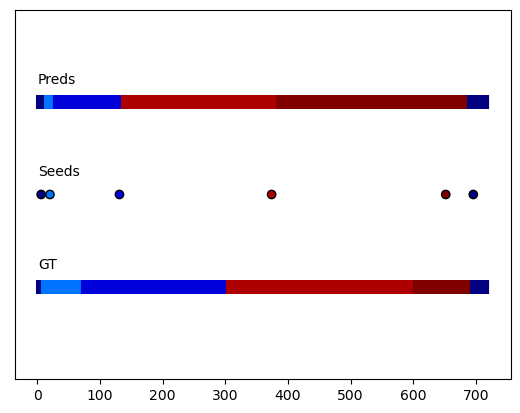

Finish vid: P40_cam02_P40_pancake.txt | Acc 0.606
Finish vid: P40_cam02_P40_salat.txt | Acc 0.737
Finish vid: P40_cam02_P40_sandwich.txt | Acc 0.740
Finish vid: P40_cam02_P40_scrambledegg.txt | Acc 0.746
Finish vid: P40_cam02_P40_tea.txt | Acc 0.895
Finish vid: P40_stereo01_P40_cereals.txt | Acc 0.871
Finish vid: P40_stereo01_P40_coffee.txt | Acc 0.668
Finish vid: P40_stereo01_P40_friedegg.txt | Acc 0.729
Finish vid: P40_stereo01_P40_juice.txt | Acc 0.685
Finish vid: P40_stereo01_P40_milk.txt | Acc 0.442
Finish vid: P40_stereo01_P40_sandwich.txt | Acc 0.699
Finish vid: P40_stereo01_P40_scrambledegg.txt | Acc 0.766
Finish vid: P40_stereo01_P40_tea.txt | Acc 0.654
Finish vid: P40_webcam01_P40_cereals.txt | Acc 0.853
Finish vid: P40_webcam01_P40_coffee.txt | Acc 0.530
Finish vid: P40_webcam01_P40_friedegg.txt | Acc 0.822
Finish vid: P40_webcam01_P40_juice.txt | Acc 0.518
Finish vid: P40_webcam01_P40_milk.txt | Acc 0.767
Finish vid: P40_webcam01_P40_pancake.txt | Acc 0.451
Finish vid: P40_

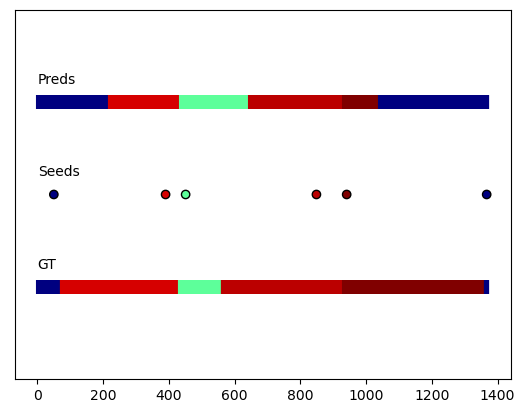

Finish vid: P42_cam02_P42_scrambledegg.txt | Acc 0.531
Finish vid: P42_cam02_P42_tea.txt | Acc 0.678
Finish vid: P42_stereo01_P42_cereals.txt | Acc 0.652
Finish vid: P42_stereo01_P42_coffee.txt | Acc 0.873
Finish vid: P42_stereo01_P42_friedegg.txt | Acc 0.756
Finish vid: P42_stereo01_P42_juice.txt | Acc 0.473
Finish vid: P42_stereo01_P42_milk.txt | Acc 0.919
Finish vid: P42_stereo01_P42_pancake.txt | Acc 0.469
Finish vid: P42_stereo01_P42_sandwich.txt | Acc 0.642
Finish vid: P42_stereo01_P42_scrambledegg.txt | Acc 0.465
Finish vid: P42_stereo01_P42_tea.txt | Acc 0.621
Finish vid: P42_webcam01_P42_cereals.txt | Acc 0.570
Finish vid: P42_webcam01_P42_coffee.txt | Acc 0.669
Finish vid: P42_webcam01_P42_friedegg.txt | Acc 0.740
Finish vid: P42_webcam01_P42_juice.txt | Acc 0.787
Finish vid: P42_webcam01_P42_milk.txt | Acc 0.702
Finish vid: P42_webcam01_P42_pancake.txt | Acc 0.302
Finish vid: P42_webcam01_P42_salat.txt | Acc 0.768
Finish vid: P42_webcam01_P42_sandwich.txt | Acc 0.660
Finish 

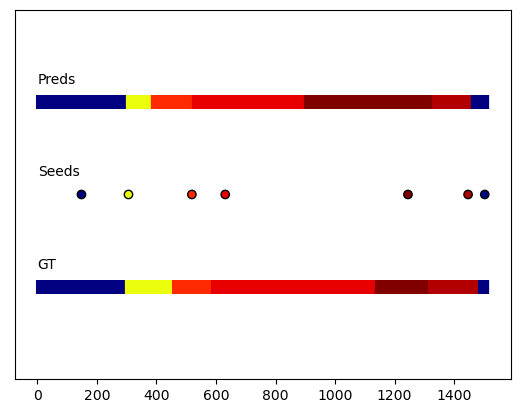

Finish vid: P44_webcam01_P44_milk.txt | Acc 0.802
Finish vid: P44_webcam01_P44_pancake.txt | Acc 0.414
Finish vid: P44_webcam01_P44_salat.txt | Acc 0.256
Finish vid: P44_webcam01_P44_sandwich.txt | Acc 0.825
Finish vid: P44_webcam01_P44_scrambledegg.txt | Acc 0.767
Finish vid: P44_webcam01_P44_tea.txt | Acc 0.725
Finish vid: P44_webcam02_P44_cereals.txt | Acc 0.789
Finish vid: P44_webcam02_P44_coffee.txt | Acc 0.848
Finish vid: P44_webcam02_P44_friedegg.txt | Acc 0.580
Finish vid: P44_webcam02_P44_juice.txt | Acc 0.821
Finish vid: P44_webcam02_P44_milk.txt | Acc 0.743
Finish vid: P44_webcam02_P44_pancake.txt | Acc 0.516
Finish vid: P44_webcam02_P44_salat.txt | Acc 0.303
Finish vid: P44_webcam02_P44_sandwich.txt | Acc 0.849
Finish vid: P44_webcam02_P44_scrambledegg.txt | Acc 0.600
Finish vid: P44_webcam02_P44_tea.txt | Acc 0.554
Finish vid: P45_cam01_P45_cereals.txt | Acc 0.558
Finish vid: P45_cam01_P45_coffee.txt | Acc 0.387
Finish vid: P45_cam01_P45_friedegg.txt | Acc 0.588
Finish vid

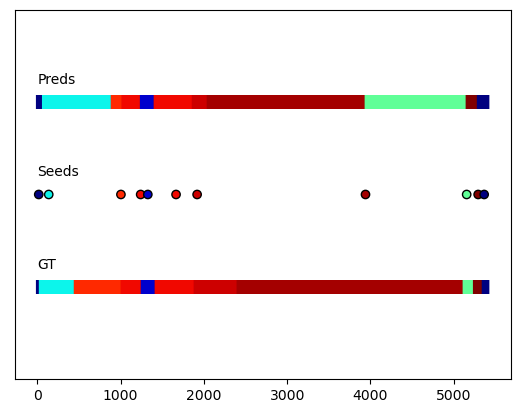

Finish vid: P46_webcam02_P46_salat.txt | Acc 0.517
Finish vid: P46_webcam02_P46_sandwich.txt | Acc 0.473
Finish vid: P46_webcam02_P46_scrambledegg.txt | Acc 0.669
Finish vid: P46_webcam02_P46_tea.txt | Acc 0.782
Finish vid: P47_cam01_P47_cereals.txt | Acc 0.897
Finish vid: P47_cam01_P47_coffee.txt | Acc 0.627
Finish vid: P47_cam01_P47_friedegg.txt | Acc 0.831
Finish vid: P47_cam01_P47_juice.txt | Acc 0.760
Finish vid: P47_cam01_P47_milk.txt | Acc 0.422
Finish vid: P47_cam01_P47_pancake.txt | Acc 0.413
Finish vid: P47_cam01_P47_salat.txt | Acc 0.508
Finish vid: P47_cam01_P47_sandwich.txt | Acc 0.753
Finish vid: P47_cam01_P47_scrambledegg.txt | Acc 0.490
Finish vid: P47_cam01_P47_tea.txt | Acc 0.689
Finish vid: P47_cam02_P47_cereals.txt | Acc 0.844
Finish vid: P47_cam02_P47_coffee.txt | Acc 0.646
Finish vid: P47_cam02_P47_friedegg.txt | Acc 0.808
Finish vid: P47_cam02_P47_juice.txt | Acc 0.624
Finish vid: P47_cam02_P47_milk.txt | Acc 0.688
Finish vid: P47_cam02_P47_pancake.txt | Acc 0.43

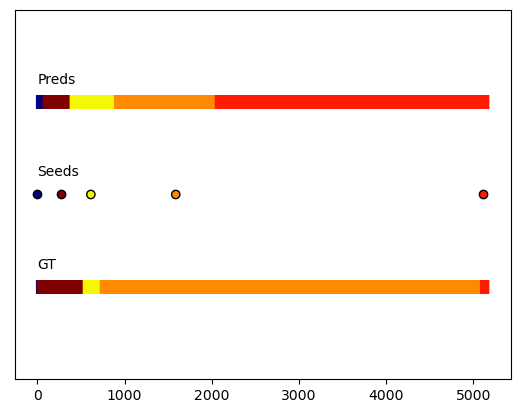

Finish vid: P49_cam02_P49_juice.txt | Acc 0.769
Finish vid: P49_cam02_P49_pancake.txt | Acc 0.579
Finish vid: P49_cam02_P49_salat.txt | Acc 0.475
Finish vid: P49_cam02_P49_sandwich.txt | Acc 0.680
Finish vid: P49_cam02_P49_scrambledegg.txt | Acc 0.501
Finish vid: P49_cam02_P49_tea.txt | Acc 0.721
Finish vid: P49_stereo01_P49_cereals.txt | Acc 0.522
Finish vid: P49_stereo01_P49_coffee.txt | Acc 0.539
Finish vid: P49_stereo01_P49_friedegg.txt | Acc 0.575
Finish vid: P49_stereo01_P49_juice.txt | Acc 0.647
Finish vid: P49_stereo01_P49_salat.txt | Acc 0.550
Finish vid: P49_stereo01_P49_sandwich.txt | Acc 0.582
Finish vid: P49_stereo01_P49_scrambledegg.txt | Acc 0.449
Finish vid: P49_stereo01_P49_tea.txt | Acc 0.412
Finish vid: P49_webcam01_P49_cereals.txt | Acc 0.617
Finish vid: P49_webcam01_P49_coffee.txt | Acc 0.670
Finish vid: P49_webcam01_P49_friedegg.txt | Acc 0.372
Finish vid: P49_webcam01_P49_juice.txt | Acc 0.702
Finish vid: P49_webcam01_P49_milk.txt | Acc 0.650
Finish vid: P49_webc

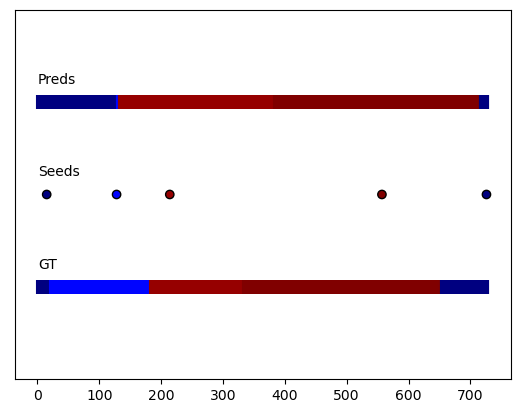

Finish vid: P51_stereo01_P51_cereals.txt | Acc 0.826
Finish vid: P51_stereo01_P51_coffee.txt | Acc 0.676
Finish vid: P51_stereo01_P51_juice.txt | Acc 0.508
Finish vid: P51_stereo01_P51_milk.txt | Acc 0.741
Finish vid: P51_stereo01_P51_salat.txt | Acc 0.696
Finish vid: P51_stereo01_P51_sandwich.txt | Acc 0.825
Finish vid: P51_stereo01_P51_tea.txt | Acc 0.571
Finish vid: P51_webcam01_P51_cereals.txt | Acc 0.765
Finish vid: P51_webcam01_P51_coffee.txt | Acc 0.685
Finish vid: P51_webcam01_P51_friedegg.txt | Acc 0.560
Finish vid: P51_webcam01_P51_juice.txt | Acc 0.623
Finish vid: P51_webcam01_P51_milk.txt | Acc 0.465
Finish vid: P51_webcam01_P51_pancake.txt | Acc 0.372
Finish vid: P51_webcam01_P51_salat.txt | Acc 0.735
Finish vid: P51_webcam01_P51_sandwich.txt | Acc 0.664
Finish vid: P51_webcam01_P51_scrambledegg.txt | Acc 0.761
Finish vid: P51_webcam01_P51_tea.txt | Acc 0.873
Finish vid: P51_webcam02_P51_cereals.txt | Acc 0.591
Finish vid: P51_webcam02_P51_coffee.txt | Acc 0.679
Finish vid

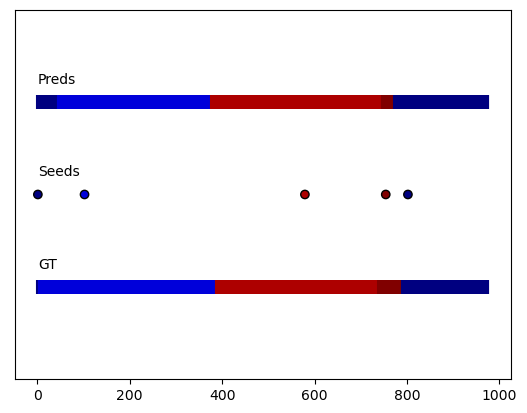

Finish vid: P53_webcam01_P53_pancake.txt | Acc 0.638
Finish vid: P53_webcam01_P53_salat.txt | Acc 0.561
Finish vid: P53_webcam01_P53_sandwich.txt | Acc 0.647
Finish vid: P53_webcam01_P53_scrambledegg.txt | Acc 0.754
Finish vid: P53_webcam01_P53_tea.txt | Acc 0.446
Finish vid: P53_webcam02_P53_cereals.txt | Acc 0.598
Finish vid: P53_webcam02_P53_coffee.txt | Acc 0.671
Finish vid: P53_webcam02_P53_friedegg.txt | Acc 0.540
Finish vid: P53_webcam02_P53_juice.txt | Acc 0.705
Finish vid: P53_webcam02_P53_milk.txt | Acc 0.843
Finish vid: P53_webcam02_P53_pancake.txt | Acc 0.473
Finish vid: P53_webcam02_P53_salat.txt | Acc 0.562
Finish vid: P53_webcam02_P53_sandwich.txt | Acc 0.474
Finish vid: P53_webcam02_P53_scrambledegg.txt | Acc 0.719
Finish vid: P53_webcam02_P53_tea.txt | Acc 0.385
Finish vid: P54_cam01_P54_cereals.txt | Acc 0.662
Finish vid: P54_cam01_P54_friedegg.txt | Acc 0.747
Finish vid: P54_cam01_P54_juice.txt | Acc 0.658
Finish vid: P54_cam01_P54_pancake.txt | Acc 0.723
Finish vid:

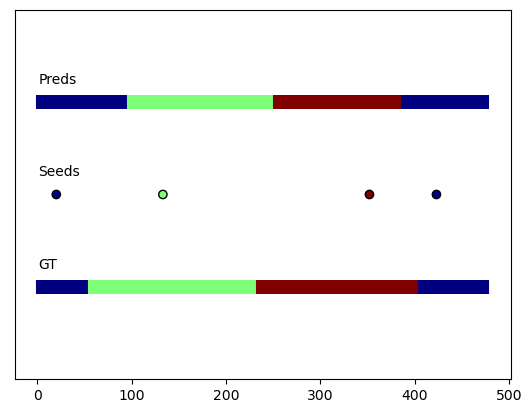

Finish vid: P04_webcam01_P04_friedegg.txt | Acc 0.338
Finish vid: P04_webcam01_P04_milk.txt | Acc 0.738
Finish vid: P04_webcam01_P04_pancake.txt | Acc 0.724
Finish vid: P04_webcam01_P04_salat.txt | Acc 0.462
Finish vid: P04_webcam01_P04_sandwich.txt | Acc 0.735
Finish vid: P04_webcam01_P04_scrambledegg.txt | Acc 0.428
Finish vid: P04_webcam01_P04_tea.txt | Acc 0.828
Finish vid: P04_webcam02_P04_cereals.txt | Acc 0.875
Finish vid: P04_webcam02_P04_friedegg.txt | Acc 0.313
Finish vid: P04_webcam02_P04_milk.txt | Acc 0.842
Finish vid: P04_webcam02_P04_pancake.txt | Acc 0.650
Finish vid: P04_webcam02_P04_salat.txt | Acc 0.673
Finish vid: P04_webcam02_P04_sandwich.txt | Acc 0.435
Finish vid: P04_webcam02_P04_scrambledegg.txt | Acc 0.566
Finish vid: P04_webcam02_P04_tea.txt | Acc 0.760
Finish vid: P05_cam01_P05_cereals.txt | Acc 0.585
Finish vid: P05_cam01_P05_coffee.txt | Acc 0.645
Finish vid: P05_cam01_P05_friedegg.txt | Acc 0.503
Finish vid: P05_cam01_P05_juice.txt | Acc 0.297
Finish vid:

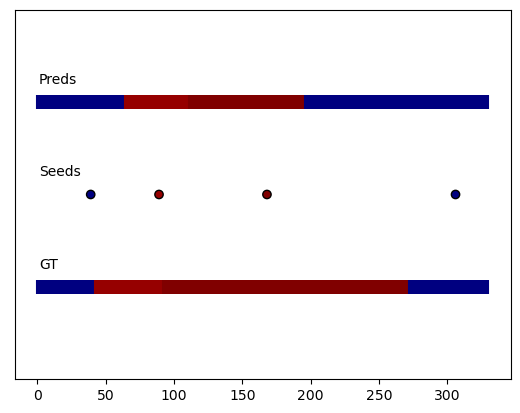

Finish vid: P11_stereo01_P11_milk.txt | Acc 0.766
Finish vid: P11_webcam01_P11_cereals.txt | Acc 0.768
Finish vid: P11_webcam01_P11_coffee.txt | Acc 0.879
Finish vid: P11_webcam01_P11_friedegg.txt | Acc 0.656
Finish vid: P11_webcam01_P11_milk.txt | Acc 0.634
Finish vid: P11_webcam01_P11_pancake.txt | Acc 0.804
Finish vid: P11_webcam01_P11_salat.txt | Acc 0.562
Finish vid: P11_webcam01_P11_sandwich.txt | Acc 0.742
Finish vid: P11_webcam01_P11_scrambledegg.txt | Acc 0.713
Finish vid: P11_webcam01_P11_tea.txt | Acc 0.631
Finish vid: P12_cam01_P12_cereals.txt | Acc 0.771
Finish vid: P12_cam01_P12_coffee.txt | Acc 0.944
Finish vid: P12_cam01_P12_friedegg.txt | Acc 0.259
Finish vid: P12_cam01_P12_milk.txt | Acc 0.674
Finish vid: P12_cam01_P12_pancake.txt | Acc 0.650
Finish vid: P12_cam01_P12_salat.txt | Acc 0.724
Finish vid: P12_cam01_P12_sandwich.txt | Acc 0.898
Finish vid: P12_cam01_P12_scrambledegg.txt | Acc 0.675
Finish vid: P12_cam01_P12_tea.txt | Acc 0.820
Finish vid: P12_stereo01_P12_

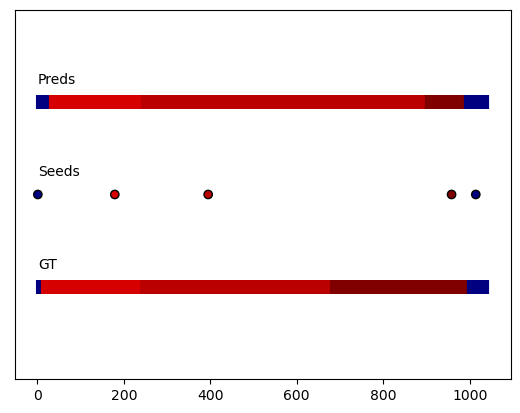

Finish vid: P15_stereo01_P15_scrambledegg.txt | Acc 0.571
Finish vid: P15_stereo01_P15_tea.txt | Acc 0.621
Finish vid: P15_webcam01_P15_cereals.txt | Acc 0.902
Finish vid: P15_webcam01_P15_coffee.txt | Acc 0.869
Finish vid: P15_webcam01_P15_friedegg.txt | Acc 0.642
Finish vid: P15_webcam01_P15_juice.txt | Acc 0.672
Finish vid: P15_webcam01_P15_milk.txt | Acc 0.915
Finish vid: P15_webcam01_P15_pancake.txt | Acc 0.497
Finish vid: P15_webcam01_P15_sandwich.txt | Acc 0.776
Finish vid: P15_webcam01_P15_scrambledegg.txt | Acc 0.636
Finish vid: P15_webcam01_P15_tea.txt | Acc 0.782
Finish all videos, mean acc: 0.646


In [95]:
run_naive_method_over_dataset(dataset='breakfast', plot_every=100)

In [74]:
def extract_prior(vid_name, labels, timestamps, actions_dict, value=1., smooth=None):
  # sparse_prior.shape [num_frames, num_classes]

  duration = len(labels)
  sparse_prior = np.zeros((len(labels), len(actions_dict)))
  for j in timestamps:
    i = labels[j]
    sparse_prior[j, i] = value
    if smooth:
      for m, n in enumerate(range(j - smooth, j)):
        if n >= 0:
          sparse_prior[n, i] = (value / (smooth + 1) * (m + 1))
      for m, n in enumerate(range(j + smooth, j, -1)):
        if n < duration:
          sparse_prior[n, i] = (value / (smooth + 1) * (m + 1))
  return sparse_prior


def run_random_walk_over_dataset(dataset = '50salads', params= {}):
  vid_name2rw_preds = {}
  acc = []
  split = '1'

  vid_list_file = "./data/"+dataset+"/splits/train.split"+split+".bundle"
  vid_list_file_tst = "./data/"+dataset+"/splits/test.split"+split+".bundle"
  features_path = "./data/"+dataset+"/features/"
  gt_path = "./data/"+dataset+"/groundTruth/"
  mapping_file = "./data/"+dataset+"/mapping.txt"

  file_ptr = open(vid_list_file, 'r')
  list_of_examples_train = file_ptr.read().split('\n')[:-1]
  file_ptr.close()
  file_ptr = open(vid_list_file_tst, 'r')
  list_of_examples_test = file_ptr.read().split('\n')[:-1]
  file_ptr.close()
  list_of_examples = list_of_examples_train + list_of_examples_test
  print('Loaded {} files'.format(len(list_of_examples)))

  timestamps_dict = np.load(gt_path + dataset + "_annotation_all.npy", allow_pickle=True).item()
  file_ptr = open(mapping_file, 'r')
  actions = file_ptr.read().split('\n')[:-1]
  file_ptr.close()
  actions_dict = dict()
  for a in actions:
      actions_dict[a.split()[1]] = int(a.split()[0])

  for vid_name in list_of_examples:
    file_ptr = open(gt_path + vid_name, 'r')
    labels_str = file_ptr.read().split('\n')[:-1]
    labels = [actions_dict[l] for l in labels_str]
    timestamps = timestamps_dict[vid_name]
    features = np.load(features_path + vid_name.split('.')[0] + '.npy').T
    if dataset == '50salads':
        features = features[::2, :]
        labels = labels[::2]

    prior = extract_prior(vid_name, labels, timestamps, actions_dict, value=1., smooth=params['smooth'])
    
    preds = run_random_walk(features, prior, params)
    acc.append((labels == preds).mean())
    vid_name2rw_preds[vid_name] = preds
    print('Finish vid: {} | Acc {:.3f}'.format(vid_name, acc[-1]))
  print('Finish all videos, mean acc: {:.3f}'.format(np.mean(acc)))
  rw_file_name = "./data/"+dataset+"/rw_preds.pickle"
  with open(rw_file_name, 'wb') as handle:
    pickle.dump(vid_name2rw_preds, handle)

run_random_walk_over_dataset('gtea', params)

Loaded 28 files
Finish vid: S2_Cheese_C1.txt | Acc 0.637
Finish vid: S2_CofHoney_C1.txt | Acc 0.714
Finish vid: S2_Coffee_C1.txt | Acc 0.782
Finish vid: S2_Hotdog_C1.txt | Acc 0.772
Finish vid: S2_Pealate_C1.txt | Acc 0.792
Finish vid: S2_Peanut_C1.txt | Acc 0.796
Finish vid: S2_Tea_C1.txt | Acc 0.761
Finish vid: S3_Cheese_C1.txt | Acc 0.709
Finish vid: S3_CofHoney_C1.txt | Acc 0.749
Finish vid: S3_Coffee_C1.txt | Acc 0.716
Finish vid: S3_Hotdog_C1.txt | Acc 0.816
Finish vid: S3_Pealate_C1.txt | Acc 0.710
Finish vid: S3_Peanut_C1.txt | Acc 0.781
Finish vid: S3_Tea_C1.txt | Acc 0.750
Finish vid: S4_Cheese_C1.txt | Acc 0.716
Finish vid: S4_CofHoney_C1.txt | Acc 0.706
Finish vid: S4_Coffee_C1.txt | Acc 0.713
Finish vid: S4_Hotdog_C1.txt | Acc 0.776
Finish vid: S4_Pealate_C1.txt | Acc 0.721
Finish vid: S4_Peanut_C1.txt | Acc 0.736
Finish vid: S4_Tea_C1.txt | Acc 0.787
Finish vid: S1_Cheese_C1.txt | Acc 0.810
Finish vid: S1_CofHoney_C1.txt | Acc 0.747
Finish vid: S1_Coffee_C1.txt | Acc 0.70

In [75]:
run_random_walk_over_dataset('50salads', params)

Loaded 50 files
Finish vid: rgb-06-1.txt | Acc 0.857
Finish vid: rgb-06-2.txt | Acc 0.810
Finish vid: rgb-07-1.txt | Acc 0.702
Finish vid: rgb-07-2.txt | Acc 0.761
Finish vid: rgb-09-1.txt | Acc 0.765
Finish vid: rgb-09-2.txt | Acc 0.794
Finish vid: rgb-10-1.txt | Acc 0.752
Finish vid: rgb-10-2.txt | Acc 0.754
Finish vid: rgb-11-1.txt | Acc 0.781
Finish vid: rgb-11-2.txt | Acc 0.666
Finish vid: rgb-13-1.txt | Acc 0.764
Finish vid: rgb-13-2.txt | Acc 0.675
Finish vid: rgb-14-1.txt | Acc 0.793
Finish vid: rgb-14-2.txt | Acc 0.769
Finish vid: rgb-15-1.txt | Acc 0.828
Finish vid: rgb-15-2.txt | Acc 0.788
Finish vid: rgb-16-1.txt | Acc 0.857
Finish vid: rgb-16-2.txt | Acc 0.787
Finish vid: rgb-17-1.txt | Acc 0.827
Finish vid: rgb-17-2.txt | Acc 0.715
Finish vid: rgb-18-1.txt | Acc 0.792
Finish vid: rgb-18-2.txt | Acc 0.837
Finish vid: rgb-19-1.txt | Acc 0.794
Finish vid: rgb-19-2.txt | Acc 0.769
Finish vid: rgb-20-1.txt | Acc 0.815
Finish vid: rgb-20-2.txt | Acc 0.822
Finish vid: rgb-21-1.t

In [68]:
run_random_walk_over_dataset('breakfast', params)

Loaded 1712 files
Finish vid: P16_cam01_P16_cereals.txt | Acc 0.829
Finish vid: P16_cam01_P16_friedegg.txt | Acc 0.613
Finish vid: P16_cam01_P16_juice.txt | Acc 0.813
Finish vid: P16_cam01_P16_milk.txt | Acc 0.833
Finish vid: P16_cam01_P16_pancake.txt | Acc 0.562
Finish vid: P16_cam01_P16_salat.txt | Acc 0.854
Finish vid: P16_cam01_P16_sandwich.txt | Acc 0.855
Finish vid: P16_cam01_P16_tea.txt | Acc 0.906
Finish vid: P16_stereo01_P16_cereals.txt | Acc 0.842
Finish vid: P16_stereo01_P16_coffee.txt | Acc 0.497
Finish vid: P16_stereo01_P16_friedegg.txt | Acc 0.638
Finish vid: P16_stereo01_P16_juice.txt | Acc 0.746
Finish vid: P16_stereo01_P16_milk.txt | Acc 0.827
Finish vid: P16_stereo01_P16_pancake.txt | Acc 0.568
Finish vid: P16_stereo01_P16_salat.txt | Acc 0.615
Finish vid: P16_stereo01_P16_sandwich.txt | Acc 0.717
Finish vid: P16_stereo01_P16_scrambledegg.txt | Acc 0.733
Finish vid: P16_stereo01_P16_tea.txt | Acc 0.906
Finish vid: P16_webcam01_P16_cereals.txt | Acc 0.675
Finish vid: P

In [63]:
import pickle
from typing import Sequence, Optional, Tuple, Mapping, Callable
import functools
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import normalize
from scipy import sparse
from scipy.special import softmax
from scipy.sparse import csgraph
from scipy.signal import medfilt, medfilt2d
from scipy.optimize import curve_fit

class TemporalPriorCalculator():
  """A class for calculating the temporal prior, based on normalized histogrames."""

  def __init__(self,
               list_of_video_dicts: Sequence[Mapping[str, np.ndarray]],
               num_temporal_bins: float =10000,
               num_labels: int = 7,
               eps: float = 1e-24):
    """
    Args:
     list_of_video_dicts: A list of video dicts, each dict contains:
     {'frames': np.array, 'lables': np.array}.
     num_temporal_bins: Suggested number of bins, the effective number will be 
     the min of num_temporal_bins and the length of the shortest video.
     num_labels: The number of phases
     eps: Small value
    """

    self.num_temporal_bins = min(num_temporal_bins, min([len(item['labels']) for item in list_of_video_dicts]))
    self.temporal_bins = np.arange(0, stop=1.0, step=1/self.num_temporal_bins)
    self.num_labels = num_labels
    self.eps = eps
    self.temporal_atlas = self._build_temporal_atlas(list_of_video_dicts)

  def _build_temporal_atlas(self, list_of_video_dicts):
    """Given a list of tagged video, calculate the temporal atlas."""
    num_vids = len(list_of_video_dicts)
    atlas = np.zeros((num_vids, self.num_temporal_bins, self.num_labels))

    for i, item in enumerate(list_of_video_dicts):
      labels = item['labels']
      n = len(labels)
      prog = np.arange(n) / n
      for b, l in zip(np.digitize(prog, self.temporal_bins) - 1, labels):
        atlas[i, b, l] += 1
      atlas[i, :, :] = atlas[i, :, :] / (atlas[i, :, :].sum(axis=1) + self.eps)[:, None]
    return atlas.mean(0)

  def get_probs(self, frames):
    n = len(frames)
    prog = np.arange(n) / n
    temporal_prior = self.temporal_atlas[np.digitize(prog, self.temporal_bins) - 1, :]
    return temporal_prior
  
  def get_sparse_probs(self, frames, method='argmax'):
    probs = self.get_probs(frames)
    if method == 'argmax':
      sparse_probs = np.zeros_like(probs)
      for i, j in enumerate(probs.argmax(1)):
        sparse_probs[i, j] = 1.0
    else:
      raise ValueError('Invalid method {}'.format(method))
    return sparse_probs


def calc_multivariate_gaussian_means_and_covs(list_of_video_dicts, num_labels):
  label2frames = {n:[] for n in range(num_labels)}
  for vid in list_of_video_dicts:
    for f, v in zip(vid['frames'], vid['labels']):
      label2frames[v].append(f)

  means = {}
  covs = {}
  for l, f in label2frames.items():
    f = np.stack(f)
    means[l] = f.mean(0)
    covs[l] = np.cov(f.T)
  return means, covs


class GaussiansLikelihoodCalculator():
  """A class for calculating the spatial prior, based on gaussian likelihood."""

  def __init__(self,
               list_of_video_dicts: Sequence[Mapping[str, np.ndarray]],
               num_labels: int = 7,
               eps: float = 1e-24):
    """
    Args:
     list_of_video_dicts: A list of video dicts, each dict contains:
     {'frames': np.array, 'lables': np.array}.
     the min of num_temporal_bins and the length of the shortest video.
     num_labels: The number of phases
     eps: Small value
    """
    means, covs = calc_multivariate_gaussian_means_and_covs(list_of_video_dicts, num_labels)
    self.num_labels = num_labels
    self.hidden_dim = len(means[0])
    self.eps = eps

    self.means = means
    self.covs = covs

    self.cv_log_dets = {}
    self.cv_chols = {}
    for c in range(self.num_labels):
      mu = self.means[c]
      cv = self.covs[c]

      try:
        self.cv_chols[c] = scipy.linalg.cholesky(cv, lower=True)
      except scipy.linalg.LinAlgError:
        self.cv_chols[c] = scipy.linalg.cholesky(cv + min_covar * np.eye(self.hidden_dim), lower=True)
      self.cv_log_dets[c] = 2 * np.sum(np.log(np.diagonal(self.cv_chols[c])))

  def calc_log_probs(self, frames: np.ndarray, temp: Optional[float] = 0.1):
    """ Given a numpy array of shape (n_frames, hidden_dim), calculate the log
    probabilities of each frame to be part of each gaussian. If a temperature is
    spacified, apply softmax per phase."""

    n_samples, _ = frames.shape
    log_probs = np.empty((n_samples, self.num_labels))
    for c in range(self.num_labels):
      cv_sol = scipy.linalg.solve_triangular(self.cv_chols[c], (frames - self.means[c]).T, lower=True).T
      log_probs[:, c] = - .5 * (np.sum(cv_sol ** 2, axis=1) + \
                              self.hidden_dim * np.log(2 * np.pi) + self.cv_log_dets[c])
    if temp:
      return softmax(log_probs * temp, 1)
    else: 
      return log_probs


def sparsify_prior(probs: np.ndarray,
                   k: int,
                   method: str,
                   is_soft: bool,
                   temp: float,
                   value: float = 1):
  """A function for sparsifing dense prior.
  Args: 
   probs: The dense probability matrix
   k: TopK timestamps to keep for label
   method: The sparsifing method, in ['topk', 'ordered_topk', 'sigma_k' (k is a number)]
   is_soft: If set use soft prior for the sparse timestamps
   temp: Temperature for the soft sparse prior
   value: The value to assign for the selected sparse timestamps (not soft)

  Retures:
   sparse_prior with the same shape as the input dense prior

  """

  def _populate(probs, sparse_prior, inds, phase_num, value, temp):
    if not is_soft:
      for i in inds:
        sparse_prior[i, probs[i, :].argmax()] = value
    else:
      for i in inds:
        sparse_prior[i, :] = softmax(probs[i, :] * temp)

  sparse_prior = np.zeros_like(probs) 
  if method == 'topk':
    for pn, phase_probs in enumerate(probs.T):
      p_inds = phase_probs.argsort()[-k:].tolist()
      _populate(probs, sparse_prior, p_inds, pn, value, temp)
  elif method == 'ordered_topk':
    max_ind = 0
    for pn, phase_probs in enumerate(probs.T):
      p_inds = phase_probs[max_ind:].argsort()[-k:].tolist()
      p_inds = [max_ind + p for p in p_inds]
      _populate(probs, sparse_prior, p_inds, pn, value, temp)
      max_ind += max(p_inds)
  elif 'sigma' in method:
    l = int(method.split('_')[1])
    n = len(probs)
    inds = set()
    for pn, phase_probs in enumerate(probs.T):
      _, m, s = fit_gauss(phase_probs)
      p_inds = [int(m * n)]
      cand = int((m - (l * s))* n) 
      if cand > 0:
        p_inds.append(cand)
      cand = int((m + (l * s))* n) 
      if cand < n:
        p_inds.append(cand)
      _populate(probs, sparse_prior, p_inds, pn, value, temp)
  return sparse_prior

def merge_priors(dense_temporal_prior: np.ndarray,
                 dense_spatial_prior: np.ndarray,
                 method: str = 'mask',
                 alpha: float = 0.5,
                 value: float = 1.0):
  """Merge the temporal and the spatial priors.
  Args:
   dense_temporal_prior: np.ndarray
   dense_spatial_prior: np.ndarray
   method: The name of the merging method
   alpha: For masking with temporal prior, this is the threshold value
   value: The value to report for the sparse prior output
  Returs:
   prior, the merged prior with the same shape as the input
  """
  if method == 'mask':
    sparse_temporal_prior = np.zeros_like(dense_temporal_prior)
    for i, row in enumerate(dense_temporal_prior):
      sparse_temporal_prior[i, np.where(row > alpha * row.max())[0]] = value
      prior = dense_spatial_prior * sparse_temporal_prior
  else:
    raise ValueError('Invalid marging method {}'.format_map(method))

  return prior

def get_timestamps_prior(labels: np.ndarray,
                         num_labels: int,
                         k: int,
                         value: float = 1,
                         method: str = 'center',
                         seed: int = 0, 
                         smooth: Optional[int] = None):
  """Get sparse timestamps prior (perfect prior) from the video's labels.

  Given the list of labels for a video, sub-sample K timestamps per phase and
  report sparse timestamp prior.

  Args:
   labels: The per-frame labels of a vides
   num_labels: The number of labels
   k: The number of timestamps to subsample per phase
   value: The value fot the sparse prior
   method: Method for sampling the timestamps 
    'center' - report the central point of each phase
    'random_k' - random sample for k timestamps per phase
   seed: Seed for the random sampling process
   smooth: If specified, apply linear smoothing of the prior
  Returns:
   sparse_prior with shape (duration, num_labels)
  """
  duration = len(labels)
  sparse_prior = np.full((duration, num_labels), 0.0)
  for i in range(num_labels):
    inds = np.where(labels == i)[0]
    if len(inds):
      if method == 'center':
        inds = [int(np.mean(inds))]
      if method == 'random_k':
        inds = np.random.RandomState(seed).choice(inds, size=(k,), replace=False)
      for j in inds:
        sparse_prior[j, i] = value
        if smooth:
          for m, n in enumerate(range(j - smooth, j)):
            if n >= 0:
              sparse_prior[n, i] = (value / (smooth + 1) * (m + 1))
          for m, n in enumerate(range(j + smooth, j, -1)):
            if n < duration:
              sparse_prior[n, i] = (value / (smooth + 1) * (m + 1))

  return sparse_prior



def sparsify_affine_matrix(w_mat: np.array,
                           m: int,
                           average_method: str,
                           tau: float = 0.5,
                           post_process_fn: Callable = lambda x: x):
  """A method for sparsifying the affine matrix, to inlude 2 neighbors per node.
  Also includes logic for averaging 'm' edges weights for calculating the sparse
  affine matrix.

  Args:
   w_mat: The dense affine matrix, shape (n_frames, n_frames)
   m: The number of neighbors to aggregate weights (from one-side)
   average_method: The method for averaging the m weight's values
   tau: For Daniel's method
   post_process_fn: Post processing of the weights values.
  Returs:
   sparse_w_mat, same shape as w_mat
  """
  n = len(w_mat)
  rs = [np.array([w_mat[i, j] if j < n else 0.0 for j in range(i + 1, i + m + 1)]) for i in range(n)]
  ls = [np.array([w_mat[i, j] if j >= 0 else 0.0 for j in range(i - m, i)]) for i in range(n)]

  r = np.stack(rs, 1)[:,:-1]
  l = np.stack(ls, 1)[:,1:]

  sparse_w_mat = np.zeros_like(w_mat)
  if average_method == 'mean':
    np.fill_diagonal(sparse_w_mat[:, 1:], r.mean(0))
    np.fill_diagonal(sparse_w_mat[1:, :], l.mean(0))

  if average_method == 'weighted_mean':
    # correction for the first m rows 
    wls = []
    for j in range(1, m):
      wls.append(np.concatenate([np.zeros(m - j), np.arange(1, j + 1) / sum(np.arange(j + 1))]))
    wl_v = np.arange(1, m + 1) / sum(np.arange(m + 1))
    wl = np.concatenate([np.stack(wls), np.tile(wl_v, (len(sparse_w_mat) - m, 1))])

    wr = np.flipud(wl)
    r *= wr.T
    l *= wl.T
    np.fill_diagonal(sparse_w_mat[:, 1:], post_process_fn(r.sum(0)))
    np.fill_diagonal(sparse_w_mat[1:, :], post_process_fn(l.sum(0)))

  if average_method == 'sum':
    np.fill_diagonal(sparse_w_mat[:, 1:], r.sum(0))
    np.fill_diagonal(sparse_w_mat[1:, :], l.sum(0))

  elif average_method == 'min':
    np.fill_diagonal(sparse_w_mat[:, 1:], r.min(0))
    np.fill_diagonal(sparse_w_mat[1:, :], l.min(0))

  elif average_method == 'max':
    np.fill_diagonal(sparse_w_mat[:, 1:], r.max(0))
    np.fill_diagonal(sparse_w_mat[1:, :], l.max(0))

  elif average_method == 'daniel':
    np.fill_diagonal(sparse_w_mat[:, 1:], (r >= tau).sum(0) / m)
    np.fill_diagonal(sparse_w_mat[1:, :], (l >= tau).sum(0) / m)

  return sparse_w_mat


def get_lambda_vector(z_i, process_func=lambda z: np.power(z, 5)):
  """Get lambda vector based on the maximal temporal prior value and some post-processing function."""
  z_max = z_i.max(1)
  return process_func(z_max)


# TODO(royhirsch) : old method
def get_laplacian_matrix(w_mat: np.array,
                         neighborhood_size: int = 1,
                         step: int = 1):
  """By-the-book calculation of the laplacian matrix given the dense weights matrix."""

  n = len(w_mat)
  lap = np.zeros((n, n))
  for i in range(step, (neighborhood_size + 1)*step, step):
    np.fill_diagonal(lap[:, i:], -1.0 * w_mat.diagonal(offset=i))
    np.fill_diagonal(lap[i:, :], -1.0 * w_mat.diagonal(offset=-i))

  lap[np.diag_indices(n)] = -1.0 * lap.sum(1)
  return lap

def power(x, a):
  return np.power(x, a)


def solve(laplacian, prior, gamma=1e-2):
  """Solve Ax = b with the for s phases with temporal prior.
   can be a vector or a scalar.
  """

  n = len(laplacian)
  if isinstance(gamma, (int, float)):
    gamma_vec = np.full(shape=(n,), fill_value=gamma) 
  else:
    gamma_vec = gamma_vec

  prior = prior.T
  lap_sparse = sparse.csr_matrix(laplacian) 
  gamma_sparse = sparse.coo_matrix((gamma_vec, (range(n), range(n))))
  A_sparse = lap_sparse + gamma_sparse
  A_sparse = A_sparse.tocsc()
  solver = sparse.linalg.factorized(A_sparse.astype(np.double))
  X = np.array([solver(gamma_vec * label_prior) for label_prior in prior])
  return X


def predict(laplacian, prior, gamma=1e-2):
  """Solve and predict with argmax"""

  X = solve(laplacian, prior, gamma=1e-2)
  preds = np.argmax(X, axis=0)
  return preds


def acc(preds, labels):
  return (preds == labels).mean()


def sparse_acc(labels, sparse_prior):
  valid_inds = np.where(sparse_prior.sum(1)!=0)[0]
  return (labels[valid_inds] == sparse_prior[valid_inds].argmax(1)).mean()

class MetricsLogger():
  def __init__(self, overlaps=[0.1, 0.25, 0.5], num_classes=7):
    self.overlaps = overlaps
    self.num_classes = num_classes
    self.reset()

  def reset(self):
    self.mets = {'acc': []}
    for o in self.overlaps:
      self.mets[f'seg_f1@{o}'] = []

  def update(self, labels, preds):
    self.mets['acc'].append(acc(labels, preds))
    for o in self.overlaps:
      self.mets[f'seg_f1@{o}'].append(action_segmentetion_metrics.segmental_f1_score_video(
          y_true=labels,
          y_pred=preds,
          num_classes=self.num_classes,
          bg_class=None,
          threshold=o))
      
  def report(self):
    return {k: np.mean(v) for k, v in self.mets.items()}


  def print(self):
    res = self.report()
    print('\n')
    print('| '.join(['{}: {:.4f}'.format(k, v) for k, v in res.items()]))


def plot_bars_with_seeds(labels, preds, sparse_spatial_prior):
  n = len(preds)
  x = np.arange(n)
  ss = [100] * n

  xs = []
  ys = []
  for i, (s, j) in enumerate(zip(sparse_spatial_prior.sum(1), sparse_spatial_prior.argmax(1))):
    if s != 0.0:
      xs.append(i)  
      ys.append(j)

  plt.scatter(xs, [1.1]*len(xs), c=ys, edgecolors="black", cmap='jet')
  plt.scatter(x, [1.2]*n, s=ss, marker="|", c=preds, cmap='jet')
  plt.scatter(x, [1]*n, s=ss, marker="|", c=labels, cmap='jet')

  plt.annotate("GT",(1, 1.02))
  plt.annotate("Seeds",(1, 1.12))
  plt.annotate("Preds",(1, 1.22))

  plt.ylim([0.9, 1.3])
  plt.yticks([])
  plt.show()
